In [144]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage import io, transform, exposure
%matplotlib widget

import core

def generate_gif(array):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],
                    animated=True,
                    cmap='turbo',
                    vmin=array.min(),
                    vmax=array.max())
    def init():
        im.set_data(array[0, :, :])
        return im,
    def animate(i):
        im.set_array(array[i, :, :])
        return im,
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=array.shape[0],
                                   interval=200,
                                   blit=True)
    # anim.save("test.gif")
    plt.colorbar(label='turbo', shrink=0.75)
    plt.tight_layout()
    plt.show()

In [21]:
h5 = h5py.File("D:/Research/CoNi_16/Data/3D/CoNi16_aligned.dream3d", 'r')
data = h5["DataContainers/ImageDataContainer/CellData/SEM"][:,:,:,0]
h5.close()
ebsd = io.imread("Slice420_CoNi16/ebsd.tif")
# EBSD CROP: remove last row (0:-1) and remove first 10 columns (10:)
data = data[:, :-1, 10:]
print(data.shape, ebsd.shape)

(460, 483, 644) (483, 644)


float64
uint8
Mininum:
  start->173
  end->1817
  val->52649850.429708384


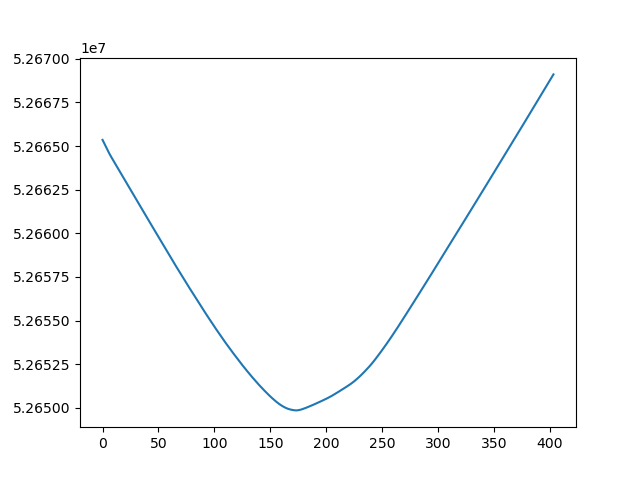

In [164]:
plt.close()
bse_full = io.imread("Slice420_CoNi16/aligned_0039.tif", as_gray=True)
bse_full = np.around(255*bse_full/bse_full.max(), 0).astype(np.uint8)
bse_resized = io.imread("Slice420_CoNi16/bse.tif")
# dx = 2192 (490:2682), dy = 1644 (173:1817)
start = np.arange(0, bse_full.shape[0] - 1644, 1, dtype=int)
end = start + 1644
diffs = []
for i in range(end.shape[0]):
    bse_full_crop = bse_full[start[i]:end[i], 490:2682]
    bse_adjusted = transform.resize(bse_full_crop, ebsd.shape, anti_aliasing=True)
    true = bse_resized
    alt = bse_adjusted
    diffs.append(np.sum(true-alt))
i = diffs.index(min(diffs))
print(f"Mininum:\n  start->{start[i]}\n  end->{end[i]}\n  val->{diffs[i]}")
plt.plot(start, diffs)
plt.show()
# fig = plt.figure(figsize=(12,4))
# ax1 = fig.add_subplot(121)
# ax1.imshow(bse_adjusted[90:110, 300:320])
# ax1.set_title("The one im adjusting")
# ax2 = fig.add_subplot(122)
# ax2.imshow((bse_adjusted-bse_resized)[90:110, 300:320])
# ax2.set_title("Target")
# ax1.grid()
# ax2.grid()
# plt.show()